# Calculation of control fields for Lindbladian dynamics using L-BFGS-B algorithm

Christian Arenz (christianarenz.ca@gmail.com), Alexander Pitchford (alex.pitchford@gmail.com)

Example to demonstrate using the control library to determine control pulses using the ctrlpulseoptim.optimize_pulse function. The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which in this case is given by the 'Trace difference' norm.

This in an open quantum system example, with a single qubit subject to an amplitude damping channel. The target evolution is the Hadamard gate. For a $d$ dimensional quantum system in general we represent the Lindbladian
as a $d^2 \times d^2$ dimensional matrix by creating the Liouvillian superoperator. Here done for the Lindbladian that describes the amplitude damping channel. Similarly the control generators acting on the qubit are also converted to superoperators. The initial and target maps also need to be in superoperator form. 

The user can experiment with the strength of the amplitude damping by changing the gamma variable value. If the rate is sufficiently small then the target fidelity can be achieved within the given tolerence. The drift Hamiltonian and control generators can also be swapped and changed to experiment with controllable and uncontrollable setups.

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

For more background on the pulse optimisation see:
[QuTiP overview - Optimal Control](http://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/example-optimal-control-overview.ipynb)  

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qutip import *
from qutip.control import *

In [41]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, sigmam, tensor
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

example_name = 'Lindblad'

In [42]:
U = cnot()
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  """Entry point for launching an IPython kernel.


In [43]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)
#Hadamard gate
had_gate = hadamard_transform(1)

# Hamiltonian
Del = 0.1    # Tunnelling term
wq = 1.0   # Energy of the 2-level system.
H0 = 0.5*wq*sigmaz() + 0.5*Del*sigmax()

#Amplitude damping#
#Damping rate:
gamma = 0.1
L0 = liouvillian(tensor(H0, H0), tensor([np.sqrt(gamma)*Sm, np.sqrt(gamma)*Sm]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  import sys


In [44]:
U = cnot()
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  """Entry point for launching an IPython kernel.


### Defining the physics

In [45]:
#Drift
drift = L0
#Controls - different combinations can be tried
ctrls = [liouvillian(X) for X in H_ops]
# Number of ctrls
n_ctrls = len(ctrls)

S_ii = tensor(Si, Si)
# start point for the map evolution
E0 = sprepost(S_ii, S_ii)

# target for map evolution
E_targ = sprepost(cnot(), cnot())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  del sys.path[0]


### Defining the time evolution parameters

In [46]:
# Number of time slots
n_ts = 100
# Time allowed for the evolution
evo_time = 20

### Set the conditions which will cause the pulse optimisation to terminate

In [47]:
# Fidelity error target
fid_err_targ = 1e-4
# Maximum iterations for the optisation algorithm
max_iter = 300
# Maximum (elapsed) time allowed in seconds
max_wall_time = 30
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

In [48]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'

### Give an extension for output files

In [49]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In [50]:
# Note that this call will take the defaults
#    dyn_type='GEN_MAT'
# This means that matrices that describe the dynamics are assumed to be
# general, i.e. the propagator can be calculated using:
# expm(combined_dynamics*dt)
#    prop_type='FRECHET'
# and the propagators and their gradients will be calculated using the
# Frechet method, i.e. an exact gradent
#    fid_type='TRACEDIFF'
# and that the fidelity error, i.e. distance from the target, is give
# by the trace of the difference between the target and evolved operators 
result = cpo.optimize_pulse(drift, ctrls, E0, E_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching False
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift dynamics generator:
Quantum object: dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape = (16, 16), type = super, isherm = False
Qobj data =
[[-0.01 +0.j      0.   -0.025j   0.   -0.025j   0.   -0.0025j
   0.   +0.025j   0.   +0.j      0.   +0.j      0.   +0.j
   0.   +0.025j   0.   +0.j      0.   +0.j      0.   +0.j
   0.   +0.0025j  0.   +0.j      0.   +0.j      0.   +0.j    ]
 [ 0.   -0.025j  -0.005+0.5j     0.   -0.0025j  0.   +0.025j
   0.   +0.j      0.   +0.025j   0.   +0.j      0.   +0.j
   0.   +0.j      0.   +0.025j 

INFO:qutip.control.pulseoptim:Initial amplitudes output to file: ctrl_amps_initial_Lindblad_n_ts100_ptypeRND.txt
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.pulseoptim:Final amplitudes output to file: ctrl_amps_final_Lindblad_n_ts100_ptypeRND.txt


### Report the results

In [51]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:30.150386
Wall time computing Hamiltonians: 0:00:00.420643 (1.40%)
Wall time computing propagators: 0:00:27.075208 (89.80%)
Wall time computing forward propagation: 0:00:00.049599 (0.16%)
Wall time computing onward propagation: 0:00:00.045857 (0.15%)
Wall time computing gradient: 0:00:02.466637 (8.18%)

**** Iterations and function calls ****
Number of iterations: 85
Number of fidelity function calls: 110
Number of times fidelity is computed: 110
Number of gradient function calls: 110
Number of times gradients are computed: 110
Number of times timeslot evolution is recomputed: 110

**** Control amplitudes ****
Number of control amplitude updates: 109
Mean number of updates per iteration: 1.2823529411764707
Number of timeslot values changed: 10900
Mean number of timeslot changes per update: 100.0
Number of amplitude values changed: 

### Plot the initial and final amplitudes

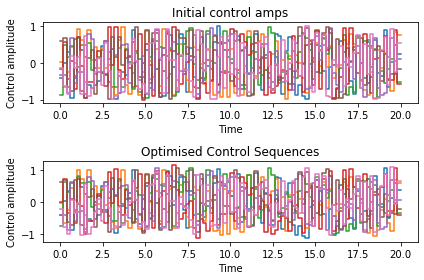

In [35]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post')
fig1.tight_layout()

### Versions

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.26
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]


In [37]:
result

In [38]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'evo_full_final',
 'evo_full_initial',
 'fid_err',
 'fidelity',
 'final_amps',
 'goal_achieved',
 'grad_norm_final',
 'grad_norm_min_reached',
 'initial_amps',
 'initial_fid_err',
 'max_fid_func_exceeded',
 'max_iter_exceeded',
 'num_fid_func_calls',
 'num_iter',
 'optimizer',
 'reset',
 'stats',
 'termination_reason',
 'time',
 'wall_time',
 'wall_time_limit_exceeded']

In [39]:
result.fidelity

0.0